We mentioned that [restricted Boltzmann machines](https://www.kaggle.com/alirezanematolahy/recommender-system-with-rbms) were a very early type of neural network and the field of deep learning has evolved considerably since then.

What happens if we apply a more contemporary neural network to the problem?
> Well, as we'll see, it's possible, but not without its challenges.

People started using deeper neural networks for recommender systems in 2015,which seems pretty recent but it's a long time in the context of current AI research.

A group from the Australian National University published a paper called AutoRec: [Autoencoders Meet Collaborative Filtering](http://users.cecs.anu.edu.au/~akmenon/papers/autorec/autorec-paper.pdf) and they used the topology you see here.

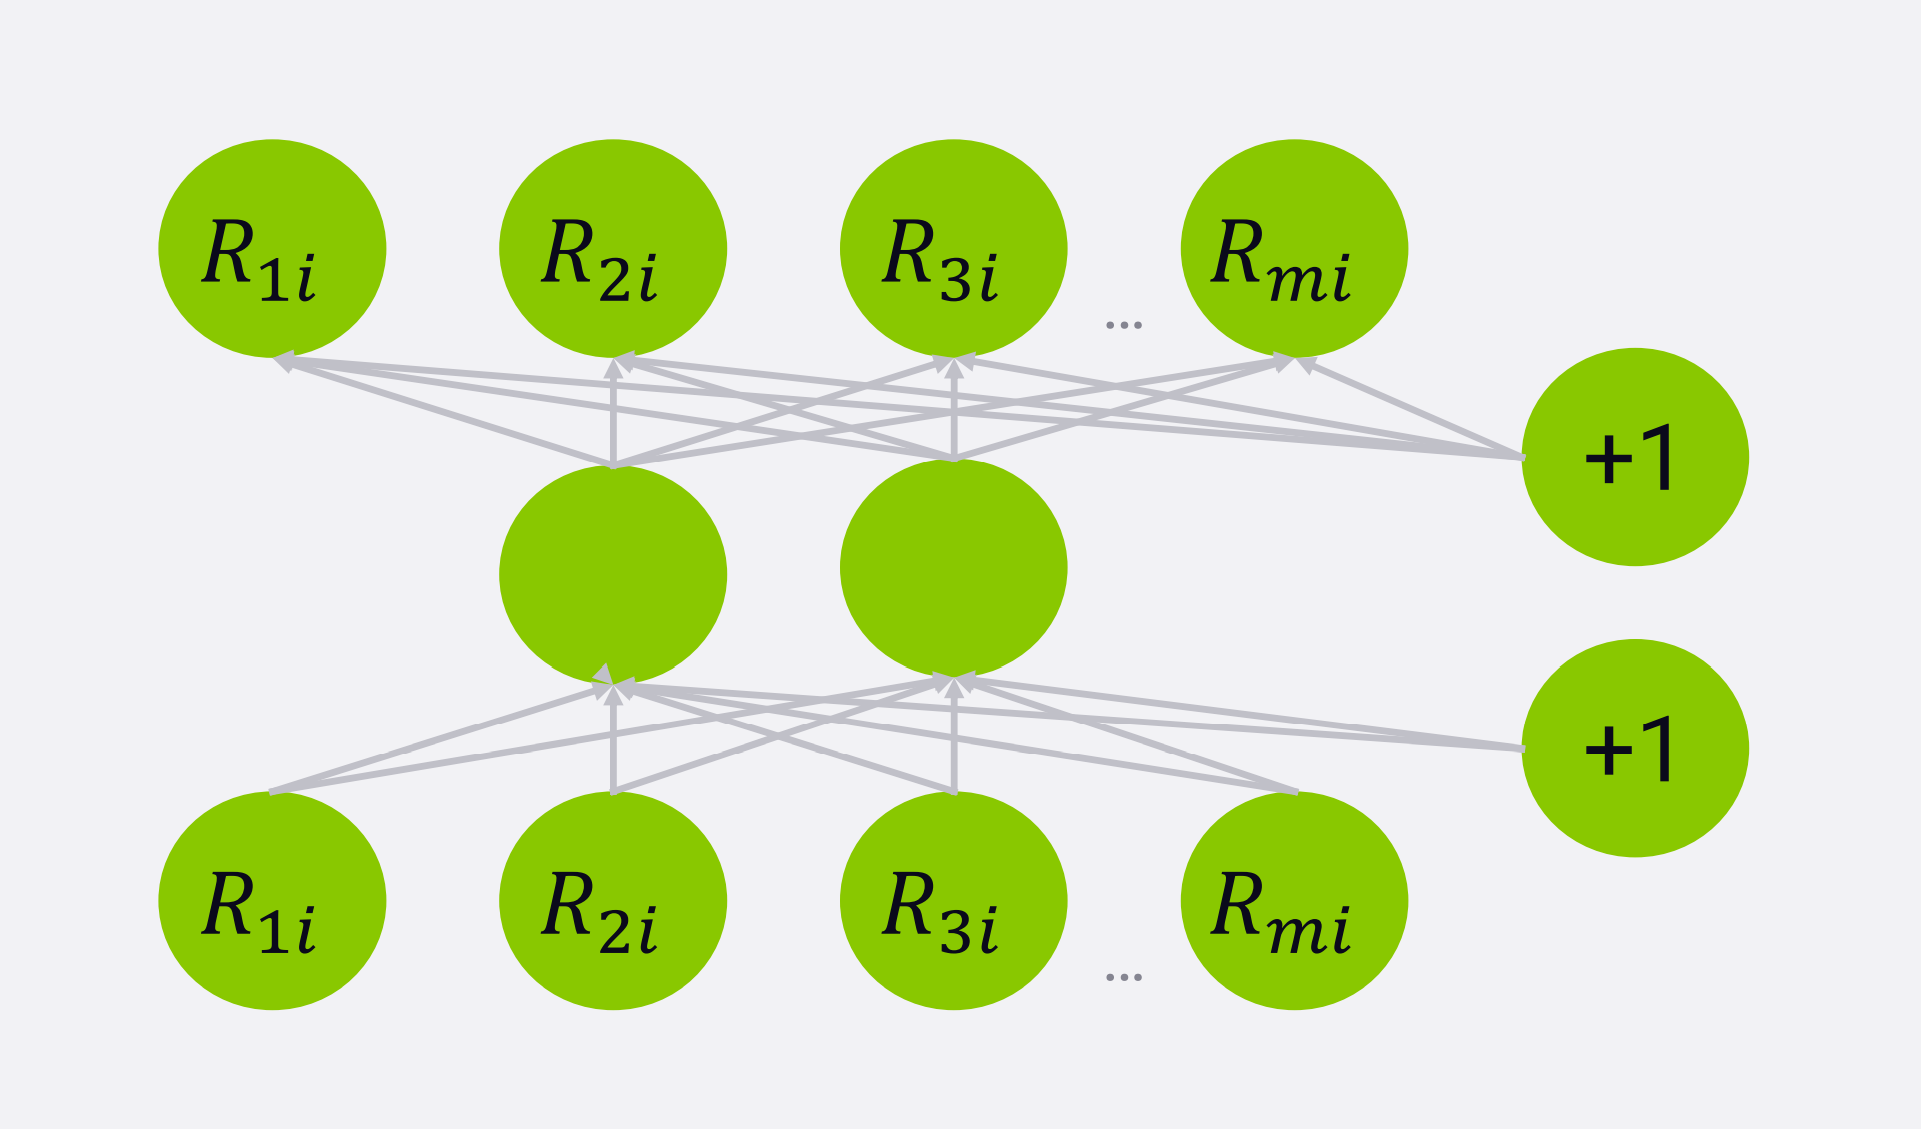

It looks a lot more familiar to the sorts of networks covered in [introduction to deep learning](https://www.kaggle.com/learn/intro-to-deep-learning). 

You have three layers:
1. an input layer on the bottom that contains individual ratings.
2. a hidden layer. 
3. an output layer that gives us our predictions.

A matrix of weights between the layers is maintained across every instance of this network, as well as a bias node for both the hidden and output layers.

In the [paper](http://users.cecs.anu.edu.au/~akmenon/papers/autorec/autorec-paper.pdf), they trained the network once per item, feeding in ratings from each user for that item in the input layer.

A sigmoid activation function was used on the output.

All in all, it's a pretty straightforward approach, and they reported slightly better results compared to using an [RBM](https://www.kaggle.com/alirezanematolahy/recommender-system-with-rbms).

But the implementation is a bit different. [RBMs](https://www.kaggle.com/alirezanematolahy/recommender-system-with-rbms) just had separate bias terms for each pass, while here we have a whole separate set of weights to work with too.
This sort of architecture also has the benefit of being a lot easier to implement in modern frameworks such as TensorFlow or Keras. But there's still one wrinkle:
> the sparsity of the data we are working with.

In the [paper](http://users.cecs.anu.edu.au/~akmenon/papers/autorec/autorec-paper.pdf) they briefly mentioned that "We only consider the contribution of observed ratings." So they were careful to process each path through this neural network individually, only propagating information from ratings that actually exist in the training data, and ignoring the contribution from input nodes that correspond to missing data from user-item pairs that weren't rated at all.
This is still a tough thing to do in TensorFlow. While TensorFlow does have sparse tensors, there's no simple way to restrict the chain of matrix multiplications and additions needed to implement a neural network to just the input nodes with actual data in them.

Any implementation you'll find of this using TensorFlow or Keras just ignores that problem, and models missing ratings as zeroes. You can still get decent results with enough effort, but it's a very fundamental problem to applying deep learning to recommender systems.


This architecture is referred to as an autoencoder. The act of building up the weights and biases between the input and hidden layer is referred to as encoding the input.

We are encoding the patterns in the input as a set of weights into that hidden layer.

Then as we reconstruct the output in the weights between the hidden and output layers we are decoding it.

So the first set of weights is the encoding stage and the second set is the decoding stage.

Conceptually, this isn't really any different from what we were doing with [RBMs](https://www.kaggle.com/alirezanematolahy/recommender-system-with-rbms). In an RBM we encoded on the forward pass and decoded on the backward pass.

That problem hasn't stopped people from trying, however. A couple of ideas that I've seen used a few times are using deeper neural networks with more hidden layers, and one hot encoding the user and item data together into a single input layer.

That's what you see in this architecture printed out from Keras.
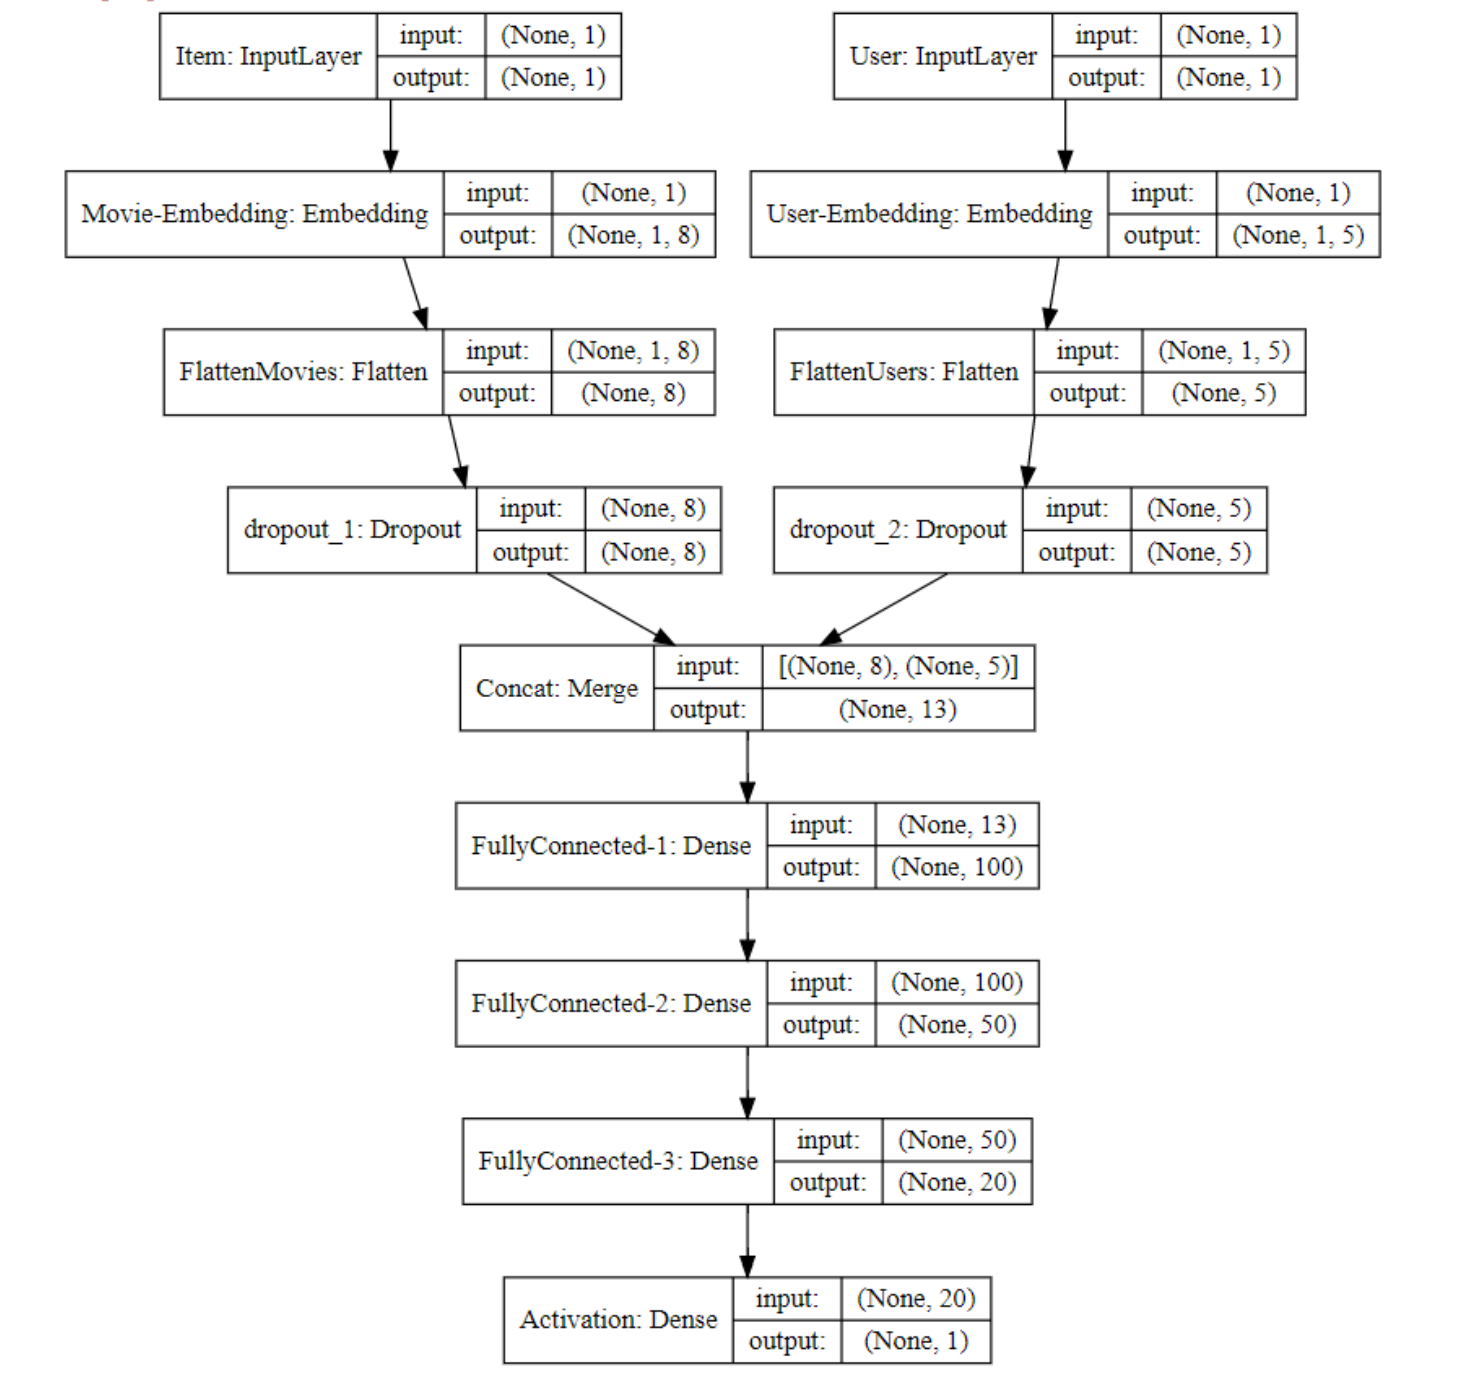
> Credit: https://nipunbatra.github.io/blog/2017/recommend-keras.html

Items are embedded on the left side, and users on the right. Both are flattened, and a dropout layer applied to prevent overfitting, and then they are concatenated together before feeding it all into a deep neural network.

But it still has the problem of not being able to distinguish between missing ratings and ratings of a value zero.

Fundamentally, it models missing ratings as a signal that a user really, really hated a given item, and that's just not an accurate representation of reality.

In the end, this particular network was unable to outperform matrix factorization on the [ML100K](https://www.kaggle.com/snehal1409/movielens) dataset. 

In part, it's due to the sparsity of the data, and it's also because 100,000 ratings just isn't anywhere near enough data to train a network as complex as this.

They actually can work quite well once you have the right tools. It's not hard, however, to implement an autoencoder in TensorFlow that just treats missing ratings as zero values, so let's give it a shot and see for ourselves how well it does.

# Auto Rec Module

Like our [RBM Example](https://www.kaggle.com/alirezanematolahy/recommender-system-with-rbms), our implementation of using and Auto Encoder for recommendations uses tensorflow and it's structured in much the same way.

As a reminder, an Auto Encoder is just a 3 layer neural network with an input layer, a hidden layer, and an output layer.

Learning the weights between the input and hidden layer is called encoding.

And reconstructing predictions with the weights between the hidden layer and the output layer is called decoding.

But fundamentally, it's just a neural network with one hidden layer.

In the MakeGraph function things are fundamentally different from the [RBM example](https://www.kaggle.com/alirezanematolahy/recommender-system-with-rbms).

It's not too complicated. You can see we're setting up the weights for the encoding and decoding here randomly initialized. Those weights are learned and shared for every user we trained the Auto Encoder with. We also set up a set of biases for both layers.

This is a little bit different from what the original Auto Rec [paper](http://users.cecs.anu.edu.au/~akmenon/papers/autorec/autorec-paper.pdf) proposed, they only had a single bias node shared across the entire layer, while we learned biases for each node, which is more in line with modern practices.

Next we set up the layers themselves. Our input layer receives ratings for each item for a given user.

We then construct our hidden layer by multiplying our input layer with the encoding weights and adding in the encoding bias terms then applying a sigmoid activation function to them.

Our output layer applies the learned decoder weights and biases to what's in the hidden layer and applies the sigmoid activation function to that final result as well.

This makes up our actual predicted ratings for every item for a given user.

To measure air, we need to compare those predicted and those are in our original input layer. So we just copy that for use in our loss function.

We define our loss function of MSE between out predicted and actual ratings and use the RMS Optimizer to minimize that error.

You might try using more modern optimization functions such as Adam if you want to tinker a bit.

The Train function kicks it all off in pretty much the same way that we did before with [RBM](https://www.kaggle.com/alirezanematolahy/recommender-system-with-rbms). Let's shift our attention to the AutoRecAlgorithm module.

In [ ]:
import numpy as np
import tensorflow as tf

class AutoRec(object):

    def __init__(self, visibleDimensions, epochs=200, hiddenDimensions=50, learningRate=0.1, batchSize=100):

        self.visibleDimensions = visibleDimensions
        self.epochs = epochs
        self.hiddenDimensions = hiddenDimensions
        self.learningRate = learningRate
        self.batchSize = batchSize
        self.optimizer = tf.keras.optimizers.RMSprop(self.learningRate)


    def Train(self, X):

        for epoch in range(self.epochs):
            for i in range(0, X.shape[0], self.batchSize):
                epochX = X[i:i+self.batchSize]
                self.run_optimization(epochX)


            print("Trained epoch ", epoch)

    def GetRecommendations(self, inputUser):

        # Feed through a single user and return predictions from the output layer.
        rec = self.neural_net(inputUser)

        # It is being used as the return type is Eager Tensor.
        return rec[0]


    def neural_net(self, inputUser):

        #tf.set_random_seed(0)

        # Create varaibles for weights for the encoding (visible->hidden) and decoding (hidden->output) stages, randomly initialized
        self.weights = {
            'h1': tf.Variable(tf.random.normal([self.visibleDimensions, self.hiddenDimensions])),
            'out': tf.Variable(tf.random.normal([self.hiddenDimensions, self.visibleDimensions]))
            }

        # Create biases
        self.biases = {
            'b1': tf.Variable(tf.random.normal([self.hiddenDimensions])),
            'out': tf.Variable(tf.random.normal([self.visibleDimensions]))
            }

        # Create the input layer
        self.inputLayer = inputUser

        # hidden layer
        hidden = tf.nn.sigmoid(tf.add(tf.matmul(self.inputLayer, self.weights['h1']), self.biases['b1']))

        # output layer for our predictions.
        self.outputLayer = tf.nn.sigmoid(tf.add(tf.matmul(hidden, self.weights['out']), self.biases['out']))

        return self.outputLayer

    def run_optimization(self, inputUser):
        with tf.GradientTape() as g:
            pred = self.neural_net(inputUser)
            loss = tf.keras.losses.MSE(inputUser, pred)

        trainable_variables = list(self.weights.values()) + list(self.biases.values())

        gradients = g.gradient(loss, trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, trainable_variables))


# AutoRecAlgorithm Module

There are a few things that have changed from the [RBM example](https://www.kaggle.com/alirezanematolahy/recommender-system-with-rbms) worth talking about.
First of all, we're not modeling this as a classification problem where each individual rating value between zero and five stars are treated as a different input and output node.

Instead we just normalize our input ratings into the range zero to one and restore them to their original ranges.

So we don't have to deal with Soft Max and Expectation Values and all that in this example.

As such our input matrix that passed into our Train function is just a 2D array of ratings between users and items.

By the way this is different from what was in the [original Auto Rec paper](http://users.cecs.anu.edu.au/~akmenon/papers/autorec/autorec-paper.pdf).

They flipped things so they trained the network on items instead of users. They would feed in all of the ratings by each user for a given item while we're feeding in the ratings for every item for each given user.

Again, if you want to tinker you might try doing it the other way to see if you get better results.

In [ ]:
from surprise import AlgoBase
from surprise import PredictionImpossible
import numpy as np

class AutoRecAlgorithm(AlgoBase):

    def __init__(self, epochs=100, hiddenDim=100, learningRate=0.01, batchSize=100, sim_options={}):
        AlgoBase.__init__(self)
        self.epochs = epochs
        self.hiddenDim = hiddenDim
        self.learningRate = learningRate
        self.batchSize = batchSize

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        numUsers = trainset.n_users
        numItems = trainset.n_items

        trainingMatrix = np.zeros([numUsers, numItems], dtype=np.float32)

        for (uid, iid, rating) in trainset.all_ratings():
            trainingMatrix[int(uid), int(iid)] = rating / 5.0

        # Create an RBM with (num items * rating values) visible nodes
        autoRec = AutoRec(trainingMatrix.shape[1], hiddenDimensions=self.hiddenDim, learningRate=self.learningRate, batchSize=self.batchSize, epochs=self.epochs)
        autoRec.Train(trainingMatrix)

        self.predictedRatings = np.zeros([numUsers, numItems], dtype=np.float32)

        for uiid in range(trainset.n_users):
            if (uiid % 50 == 0):
                print("Processing user ", uiid)
            recs = autoRec.GetRecommendations([trainingMatrix[uiid]])

            for itemID, rec in enumerate(recs):
                self.predictedRatings[uiid, itemID] = rec * 5.0

        return self


    def estimate(self, u, i):

        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unkown.')

        rating = self.predictedRatings[u, i]

        if (rating < 0.001):
            raise PredictionImpossible('No valid prediction exists.')

        return rating


# Preparing data :


In [ ]:
import os
import csv
import sys
import re

from surprise import Dataset
from surprise import Reader

from collections import defaultdict

class MovieLens:

    movieID_to_name = {}
    name_to_movieID = {}
    ratingsPath = '/kaggle/input/movielens/ratings.csv'
    moviesPath = '/kaggle/input/movielens/movies.csv'
    def loadMovieLensLatestSmall(self):

        # Look for files relative to the directory we are running from
        os.chdir(os.path.dirname(sys.argv[0]))

        ratingsDataset = 0
        self.movieID_to_name = {}
        self.name_to_movieID = {}

        reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)

        ratingsDataset = Dataset.load_from_file(self.ratingsPath, reader=reader)

        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
                movieReader = csv.reader(csvfile)
                next(movieReader)  #Skip header line
                for row in movieReader:
                    movieID = int(row[0])
                    movieName = row[1]
                    self.movieID_to_name[movieID] = movieName
                    self.name_to_movieID[movieName] = movieID

        return ratingsDataset

    def getUserRatings(self, user):
        userRatings = []
        hitUser = False
        with open(self.ratingsPath, newline='') as csvfile:
            ratingReader = csv.reader(csvfile)
            next(ratingReader)
            for row in ratingReader:
                userID = int(row[0])
                if (user == userID):
                    movieID = int(row[1])
                    rating = float(row[2])
                    userRatings.append((movieID, rating))
                    hitUser = True
                if (hitUser and (user != userID)):
                    break

        return userRatings

    def getPopularityRanks(self):
        ratings = defaultdict(int)
        rankings = defaultdict(int)
        with open(self.ratingsPath, newline='') as csvfile:
            ratingReader = csv.reader(csvfile)
            next(ratingReader)
            for row in ratingReader:
                movieID = int(row[1])
                ratings[movieID] += 1
        rank = 1
        for movieID, ratingCount in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
            rankings[movieID] = rank
            rank += 1
        return rankings

    def getGenres(self):
        genres = defaultdict(list)
        genreIDs = {}
        maxGenreID = 0
        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
            movieReader = csv.reader(csvfile)
            next(movieReader)  #Skip header line
            for row in movieReader:
                movieID = int(row[0])
                genreList = row[2].split('|')
                genreIDList = []
                for genre in genreList:
                    if genre in genreIDs:
                        genreID = genreIDs[genre]
                    else:
                        genreID = maxGenreID
                        genreIDs[genre] = genreID
                        maxGenreID += 1
                    genreIDList.append(genreID)
                genres[movieID] = genreIDList
        # Convert integer-encoded genre lists to bitfields that we can treat as vectors
        for (movieID, genreIDList) in genres.items():
            bitfield = [0] * maxGenreID
            for genreID in genreIDList:
                bitfield[genreID] = 1
            genres[movieID] = bitfield

        return genres

    def getYears(self):
        p = re.compile(r"(?:\((\d{4})\))?\s*$")
        years = defaultdict(int)
        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
            movieReader = csv.reader(csvfile)
            next(movieReader)
            for row in movieReader:
                movieID = int(row[0])
                title = row[1]
                m = p.search(title)
                year = m.group(1)
                if year:
                    years[movieID] = int(year)
        return years

    def getMiseEnScene(self):
        mes = defaultdict(list)
        with open("LLVisualFeatures13K_Log.csv", newline='') as csvfile:
            mesReader = csv.reader(csvfile)
            next(mesReader)
            for row in mesReader:
                movieID = int(row[0])
                avgShotLength = float(row[1])
                meanColorVariance = float(row[2])
                stddevColorVariance = float(row[3])
                meanMotion = float(row[4])
                stddevMotion = float(row[5])
                meanLightingKey = float(row[6])
                numShots = float(row[7])
                mes[movieID] = [avgShotLength, meanColorVariance, stddevColorVariance,
                   meanMotion, stddevMotion, meanLightingKey, numShots]
        return mes

    def getMovieName(self, movieID):
        if movieID in self.movieID_to_name:
            return self.movieID_to_name[movieID]
        else:
            return ""

    def getMovieID(self, movieName):
        if movieName in self.name_to_movieID:
            return self.name_to_movieID[movieName]
        else:
            return 0


# Evaluation Data :


In [ ]:
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise import KNNBaseline

class EvaluationData:

    def __init__(self, data, popularityRankings):

        self.rankings = popularityRankings

        #Build a full training set for evaluating overall properties
        self.fullTrainSet = data.build_full_trainset()
        self.fullAntiTestSet = self.fullTrainSet.build_anti_testset()

        #Build a 75/25 train/test split for measuring accuracy
        self.trainSet, self.testSet = train_test_split(data, test_size=.25, random_state=1)

        #Build a "leave one out" train/test split for evaluating top-N recommenders
        #And build an anti-test-set for building predictions
        LOOCV = LeaveOneOut(n_splits=1, random_state=1)
        for train, test in LOOCV.split(data):
            self.LOOCVTrain = train
            self.LOOCVTest = test

        self.LOOCVAntiTestSet = self.LOOCVTrain.build_anti_testset()

        #Compute similarty matrix between items so we can measure diversity
        sim_options = {'name': 'cosine', 'user_based': False}
        self.simsAlgo = KNNBaseline(sim_options=sim_options)
        self.simsAlgo.fit(self.fullTrainSet)

    def GetFullTrainSet(self):
        return self.fullTrainSet

    def GetFullAntiTestSet(self):
        return self.fullAntiTestSet

    def GetAntiTestSetForUser(self, testSubject):
        trainset = self.fullTrainSet
        fill = trainset.global_mean
        anti_testset = []
        u = trainset.to_inner_uid(str(testSubject))
        user_items = set([j for (j, _) in trainset.ur[u]])
        anti_testset += [(trainset.to_raw_uid(u), trainset.to_raw_iid(i), fill) for
                                 i in trainset.all_items() if
                                 i not in user_items]
        return anti_testset

    def GetTrainSet(self):
        return self.trainSet

    def GetTestSet(self):
        return self.testSet

    def GetLOOCVTrainSet(self):
        return self.LOOCVTrain

    def GetLOOCVTestSet(self):
        return self.LOOCVTest

    def GetLOOCVAntiTestSet(self):
        return self.LOOCVAntiTestSet

    def GetSimilarities(self):
        return self.simsAlgo

    def GetPopularityRankings(self):
        return self.rankings

# Evaluator Module :



In [ ]:
class Evaluator:

    algorithms = []

    def __init__(self, dataset, rankings):
        ed = EvaluationData(dataset, rankings)
        self.dataset = ed

    def AddAlgorithm(self, algorithm, name):
        alg = EvaluatedAlgorithm(algorithm, name)
        self.algorithms.append(alg)

    def Evaluate(self, doTopN):
        results = {}
        for algorithm in self.algorithms:
            print("Evaluating ", algorithm.GetName(), "...")
            results[algorithm.GetName()] = algorithm.Evaluate(self.dataset, doTopN)

        # Print results
        print("\n")

        if (doTopN):
            print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
                    "Algorithm", "RMSE", "MAE", "HR", "cHR", "ARHR", "Coverage", "Diversity", "Novelty"))
            for (name, metrics) in results.items():
                print("{:<10} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
                        name, metrics["RMSE"], metrics["MAE"], metrics["HR"], metrics["cHR"], metrics["ARHR"],
                                      metrics["Coverage"], metrics["Diversity"], metrics["Novelty"]))
        else:
            print("{:<10} {:<10} {:<10}".format("Algorithm", "RMSE", "MAE"))
            for (name, metrics) in results.items():
                print("{:<10} {:<10.4f} {:<10.4f}".format(name, metrics["RMSE"], metrics["MAE"]))

        print("\nLegend:\n")
        print("RMSE:      Root Mean Squared Error. Lower values mean better accuracy.")
        print("MAE:       Mean Absolute Error. Lower values mean better accuracy.")
        if (doTopN):
            print("HR:        Hit Rate; how often we are able to recommend a left-out rating. Higher is better.")
            print("cHR:       Cumulative Hit Rate; hit rate, confined to ratings above a certain threshold. Higher is better.")
            print("ARHR:      Average Reciprocal Hit Rank - Hit rate that takes the ranking into account. Higher is better." )
            print("Coverage:  Ratio of users for whom recommendations above a certain threshold exist. Higher is better.")
            print("Diversity: 1-S, where S is the average similarity score between every possible pair of recommendations")
            print("           for a given user. Higher means more diverse.")
            print("Novelty:   Average popularity rank of recommended items. Higher means more novel.")

    def SampleTopNRecs(self, ml, testSubject=85, k=10):

        for algo in self.algorithms:
            print("\nUsing recommender ", algo.GetName())

            print("\nBuilding recommendation model...")
            trainSet = self.dataset.GetFullTrainSet()
            algo.GetAlgorithm().fit(trainSet)

            print("Computing recommendations...")
            testSet = self.dataset.GetAntiTestSetForUser(testSubject)

            predictions = algo.GetAlgorithm().test(testSet)

            recommendations = []

            print ("\nWe recommend:")
            for userID, movieID, actualRating, estimatedRating, _ in predictions:
                intMovieID = int(movieID)
                recommendations.append((intMovieID, estimatedRating))

            recommendations.sort(key=lambda x: x[1], reverse=True)

            for ratings in recommendations[:10]:
                print(ml.getMovieName(ratings[0]), ratings[1])

# Recommender Metrics :

In [ ]:
import itertools

from surprise import accuracy
from collections import defaultdict

class RecommenderMetrics:

    def MAE(predictions):
        return accuracy.mae(predictions, verbose=False)

    def RMSE(predictions):
        return accuracy.rmse(predictions, verbose=False)

    def GetTopN(predictions, n=10, minimumRating=0.0):
        topN = defaultdict(list)


        for userID, movieID, actualRating, estimatedRating, _ in predictions:
            if (estimatedRating >= minimumRating):
                topN[int(userID)].append((int(movieID), estimatedRating))

        for userID, ratings in topN.items():
            ratings.sort(key=lambda x: x[1], reverse=True)
            topN[int(userID)] = ratings[:n]

        return topN

    def HitRate(topNPredicted, leftOutPredictions):
        hits = 0
        total = 0

        # For each left-out rating
        for leftOut in leftOutPredictions:
            userID = leftOut[0]
            leftOutMovieID = leftOut[1]
            # Is it in the predicted top 10 for this user?
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == int(movieID)):
                    hit = True
                    break
            if (hit) :
                hits += 1

            total += 1

        # Compute overall precision
        return hits/total

    def CumulativeHitRate(topNPredicted, leftOutPredictions, ratingCutoff=0):
        hits = 0
        total = 0

        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Only look at ability to recommend things the users actually liked...
            if (actualRating >= ratingCutoff):
                # Is it in the predicted top 10 for this user?
                hit = False
                for movieID, predictedRating in topNPredicted[int(userID)]:
                    if (int(leftOutMovieID) == movieID):
                        hit = True
                        break
                if (hit) :
                    hits += 1

                total += 1

        # Compute overall precision
        return hits/total

    def RatingHitRate(topNPredicted, leftOutPredictions):
        hits = defaultdict(float)
        total = defaultdict(float)

        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Is it in the predicted top N for this user?
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == movieID):
                    hit = True
                    break
            if (hit) :
                hits[actualRating] += 1

            total[actualRating] += 1

        # Compute overall precision
        for rating in sorted(hits.keys()):
            print (rating, hits[rating] / total[rating])

    def AverageReciprocalHitRank(topNPredicted, leftOutPredictions):
        summation = 0
        total = 0
        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Is it in the predicted top N for this user?
            hitRank = 0
            rank = 0
            for movieID, predictedRating in topNPredicted[int(userID)]:
                rank = rank + 1
                if (int(leftOutMovieID) == movieID):
                    hitRank = rank
                    break
            if (hitRank > 0) :
                summation += 1.0 / hitRank

            total += 1

        return summation / total

    # What percentage of users have at least one "good" recommendation
    def UserCoverage(topNPredicted, numUsers, ratingThreshold=0):
        hits = 0
        for userID in topNPredicted.keys():
            hit = False
            for movieID, predictedRating in topNPredicted[userID]:
                if (predictedRating >= ratingThreshold):
                    hit = True
                    break
            if (hit):
                hits += 1

        return hits / numUsers

    def Diversity(topNPredicted, simsAlgo):
        n = 0
        total = 0
        simsMatrix = simsAlgo.compute_similarities()
        for userID in topNPredicted.keys():
            pairs = itertools.combinations(topNPredicted[userID], 2)
            for pair in pairs:
                movie1 = pair[0][0]
                movie2 = pair[1][0]
                innerID1 = simsAlgo.trainset.to_inner_iid(str(movie1))
                innerID2 = simsAlgo.trainset.to_inner_iid(str(movie2))
                similarity = simsMatrix[innerID1][innerID2]
                total += similarity
                n += 1

        if (n > 0):
            S = total / n
            return (1-S)
        else:
            return 0

    def Novelty(topNPredicted, rankings):
        n = 0
        total = 0
        for userID in topNPredicted.keys():
            for rating in topNPredicted[userID]:
                movieID = rating[0]
                rank = rankings[movieID]
                total += rank
                n += 1
        return total / n

# Evaluated Algorithm :

In [ ]:
class EvaluatedAlgorithm:

    def __init__(self, algorithm, name):
        self.algorithm = algorithm
        self.name = name

    def Evaluate(self, evaluationData, doTopN, n=10, verbose=True):
        metrics = {}
        # Compute accuracy
        if (verbose):
            print("Evaluating accuracy...")
        self.algorithm.fit(evaluationData.GetTrainSet())
        predictions = self.algorithm.test(evaluationData.GetTestSet())
        metrics["RMSE"] = RecommenderMetrics.RMSE(predictions)
        metrics["MAE"] = RecommenderMetrics.MAE(predictions)

        if (doTopN):
            # Evaluate top-10 with Leave One Out testing
            if (verbose):
                print("Evaluating top-N with leave-one-out...")
            self.algorithm.fit(evaluationData.GetLOOCVTrainSet())
            leftOutPredictions = self.algorithm.test(evaluationData.GetLOOCVTestSet())
            # Build predictions for all ratings not in the training set
            allPredictions = self.algorithm.test(evaluationData.GetLOOCVAntiTestSet())
            # Compute top 10 recs for each user
            topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n)
            if (verbose):
                print("Computing hit-rate and rank metrics...")
            # See how often we recommended a movie the user actually rated
            metrics["HR"] = RecommenderMetrics.HitRate(topNPredicted, leftOutPredictions)
            # See how often we recommended a movie the user actually liked
            metrics["cHR"] = RecommenderMetrics.CumulativeHitRate(topNPredicted, leftOutPredictions)
            # Compute ARHR
            metrics["ARHR"] = RecommenderMetrics.AverageReciprocalHitRank(topNPredicted, leftOutPredictions)

            #Evaluate properties of recommendations on full training set
            if (verbose):
                print("Computing recommendations with full data set...")
            self.algorithm.fit(evaluationData.GetFullTrainSet())
            allPredictions = self.algorithm.test(evaluationData.GetFullAntiTestSet())
            topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n)
            if (verbose):
                print("Analyzing coverage, diversity, and novelty...")
            # Print user coverage with a minimum predicted rating of 4.0:
            metrics["Coverage"] = RecommenderMetrics.UserCoverage(  topNPredicted,
                                                                   evaluationData.GetFullTrainSet().n_users,
                                                                   ratingThreshold=4.0)
            # Measure diversity of recommendations:
            metrics["Diversity"] = RecommenderMetrics.Diversity(topNPredicted, evaluationData.GetSimilarities())

            # Measure novelty (average popularity rank of recommendations):
            metrics["Novelty"] = RecommenderMetrics.Novelty(topNPredicted,
                                                            evaluationData.GetPopularityRankings())

        if (verbose):
            print("Analysis complete.")

        return metrics

    def GetName(self):
        return self.name

    def GetAlgorithm(self):
        return self.algorithm

# AutoRec Driver Module

There's not much to talk about in what it does. It just uses our framework to compare Auto Rec to random recommendations as we've done before.

Run the next cell and it will take several minutes for it to do all of its work as we've set this up to do all of the top end metrics as well as generate some sample top-N recommendations so we can get a more comprehensive picture of how its doing.


In [ ]:
from surprise import NormalPredictor

import random
import numpy as np

def LoadMovieLensData():
    ml = MovieLens()
    print("Loading movie ratings...")
    data = ml.loadMovieLensLatestSmall()
    print("\nComputing movie popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, rankings)

np.random.seed(0)
random.seed(0)

# Load up common data set for the recommender algorithms
(ml, evaluationData, rankings) = LoadMovieLensData()

# Construct an Evaluator to, you know, evaluate them
evaluator = Evaluator(evaluationData, rankings)

#Autoencoder
AutoRecSys = AutoRecAlgorithm()
evaluator.AddAlgorithm(AutoRecSys, "AutoRec")

# Just make random recommendations
Random = NormalPredictor()
evaluator.AddAlgorithm(Random, "Random")

# Fight!
evaluator.Evaluate(True)

evaluator.SampleTopNRecs(ml)
